In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("Cleaned_and_Encoded_Cars.csv")

# Normalizing Price and Mileage
To improve the clarity of our visualizations, we will normalize Price and Mileage.

In [4]:
df['Price'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()
df['Mileage'] = (df['Mileage'] - df['Mileage'].mean()) / df['Mileage'].std()

# Normalized Price Distribution

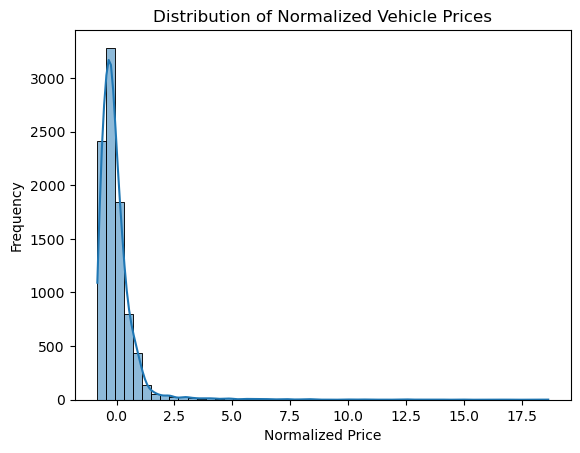

In [6]:
sns.histplot(df['Price'], kde=True, bins=50)
plt.title("Distribution of Normalized Vehicle Prices")
plt.xlabel("Normalized Price")
plt.ylabel("Frequency")
plt.show()

The distribution of vehicle prices appears slightly right skewed which suggests that while most vehicles fall within a moderate price range, there are still a number of high-priced listings that extend the tail of the distribution. The central peak indicates a strong clustering of vehicles around the average market price.

# Feature Importance Analysis (Random Forest)

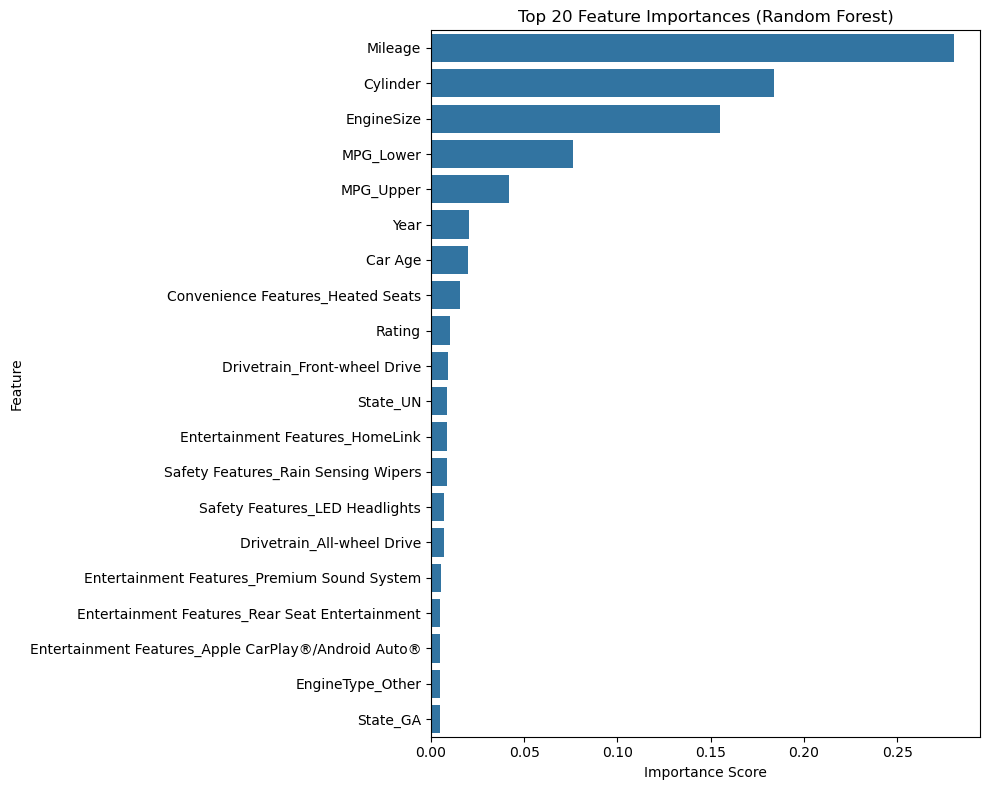

In [49]:
from sklearn.ensemble import RandomForestRegressor

df['EngineSize'] = df['EngineSize'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
df['Cylinder'] = df['Cylinder'].astype(str).str.extract(r'(\d+)').astype(float)

y = df['Price']

numerical_features = ['Rating', 'Mileage', 'Year', 'Car Age', 'MPG_Lower', 'MPG_Upper', 'EngineSize', 'Cylinder']
encoded_features = [col for col in df.columns if any(col.startswith(prefix) for prefix in [
    'Make_', 'EngineType_', 'State_', 'Drivetrain_', 'Fuel Type_', 'Transmission_Type_',
    'Convenience Features_', 'Entertainment Features_', 'Safety Features_', 'Exterior Features_'])]

X = df[numerical_features + encoded_features]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

top_20 = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_20.values, y=top_20.index)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Correlation Among Numerical Features

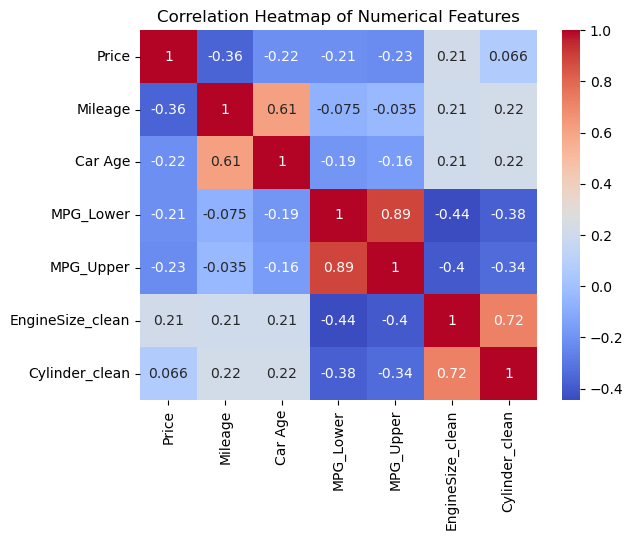

In [31]:
# Remove non-digit characters from numeric-like strings and convert
df['EngineSize_clean'] = df['EngineSize'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Cylinder_clean'] = df['Cylinder'].str.extract(r'(\d+)').astype(float)


sns.heatmap(df[['Price', 'Mileage', 'Car Age', 'MPG_Lower', 'MPG_Upper', 'EngineSize_clean', 'Cylinder_clean']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

- Mileage has a moderate negative correlation with Price (-0.36), reinforcing the depreciation effect of high usage.
- Car Age also shows a negative relationship with price (-0.22), as expected.
- MPG_Lower and MPG_Upper are highly correlated with each other (0.89), but weakly (and negatively) associated with price. This reflects the fact that more fuel-efficient vehicles tend to be lower-cost.
- Engine Size and Cylinder Count are strongly correlated (0.72), which is logical since larger engines often have more cylinders.
- The correlation between Engine Size and Price (0.21) suggests a modest relationship — larger engines may indicate higher-value or performance vehicles.

It validates Mileage and Engine Size as relevant inputs, while highlighting high correlation between fuel-related and mechanical specs like MPG and cylinders.

# Mileage vs Price

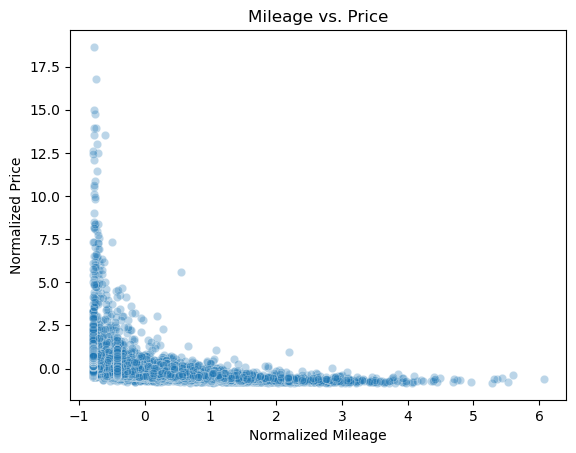

In [9]:
sns.scatterplot(x='Mileage', y='Price', data=df, alpha=0.3)
plt.title("Mileage vs. Price")
plt.xlabel("Normalized Mileage")
plt.ylabel("Normalized Price")
plt.show()

The scatterplot shows a clear negative correlation suggesting as mileage increases, the price of the vehicle generally decreases. However, noteable observation is that for vehicles with low mileage there is a great variance of prices suggesting that other features significantly influence the price. 

# Mileage Distribution by Price Quartile

C:\Users\skull\AppData\Local\Temp\ipykernel_19308\3391180069.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Price_Category', y='Mileage', data=df, palette='Blues')


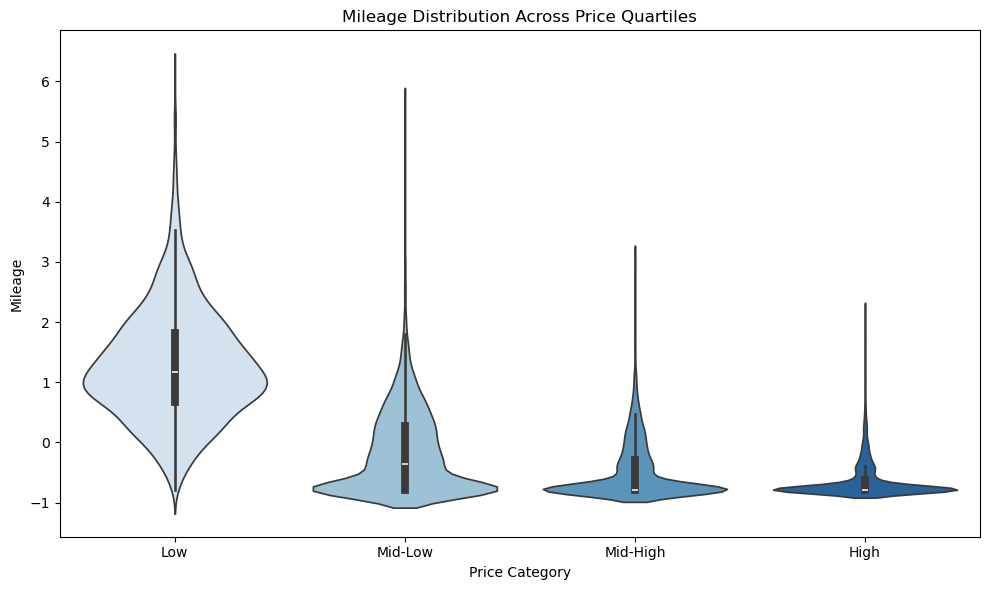

In [36]:
df['Price_Category'] = pd.qcut(df['Price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

plt.figure(figsize=(10, 6))
sns.violinplot(x='Price_Category', y='Mileage', data=df, palette='Blues')
plt.title("Mileage Distribution Across Price Quartiles")
plt.ylabel("Mileage")
plt.xlabel("Price Category")
plt.tight_layout()
plt.show()

Low-priced vehicles show the widest spread in mileage, with a noticeable concentration in the high mileage range. As we move into higher price categories, mileage becomes progressively lower and more compressed, indicating newer or less-used vehicles. The high price category exhibits the lowest mileage, with almost all listings tightly clustered at the bottom of the mileage range. 

Thus, we see that mileage has a strong inverse relationship with price,i.e. the higher mileage tends to reduce vehicle value. This supports its position as a top predictor in the feature importance analysis

# Engine Size Binned vs Price 

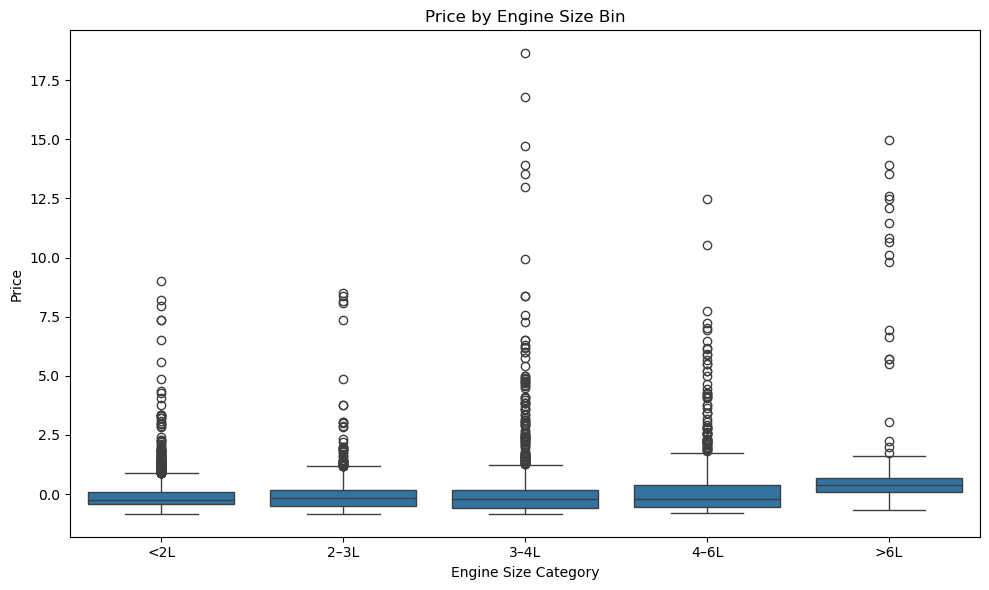

In [42]:
df['EngineSize_Bin'] = pd.cut(df['EngineSize'], bins=[0, 2.0, 3.0, 4.0, 6.0, 10.0],
                              labels=['<2L', '2–3L', '3–4L', '4–6L', '>6L'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='EngineSize_Bin', y='Price', data=df)
plt.title("Price by Engine Size Bin")
plt.xlabel("Engine Size Category")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

This visualization groups vehicles into engine size ranges to evaluate how engine capacity influences price.There's a clear positive trend that prices rise with engine size. 
Vehicles in the 4–6L and >6L categories show the highest median and maximum prices, often representing high-performance or luxury models. 
Smaller engines (e.g., <2L) cluster around lower price brackets, indicating their presence in budget-friendly or fuel-efficient cars. 
Engine size is a powerful indicator of price, reflecting both vehicle class and market expectations. Its placement in the top tier of feature importance is backed by this visual trend.

# Engine Type vs Price Boxplot

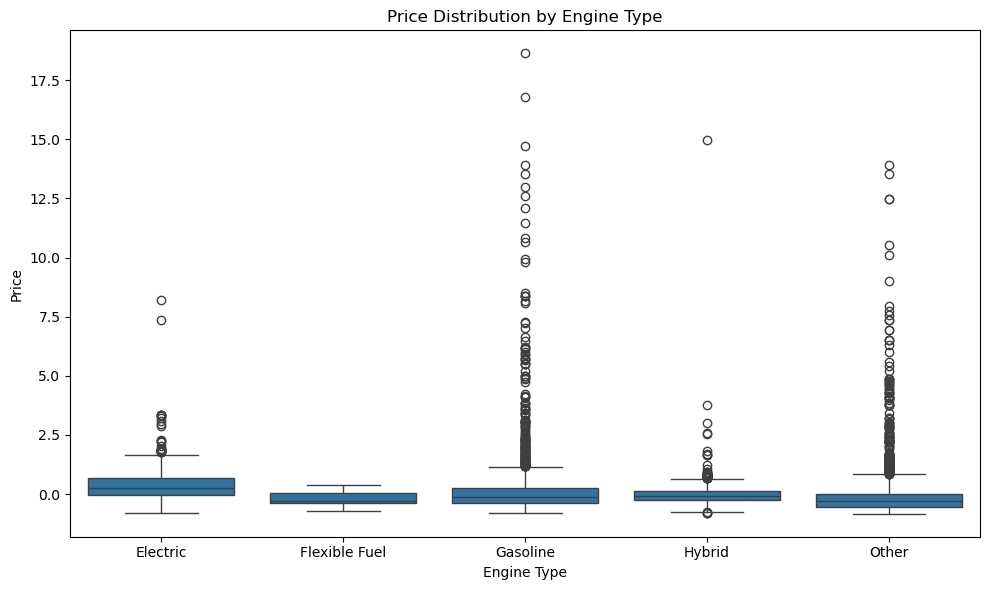

In [51]:
engine_type_cols = [col for col in df.columns if col.startswith("EngineType_")]

engine_type_price_data = pd.DataFrame()

for col in engine_type_cols:
    temp = df[[col, 'Price']].copy()
    temp['EngineType'] = col.split('_')[-1]
    temp = temp[temp[col] == 1]
    engine_type_price_data = pd.concat([engine_type_price_data, temp[['EngineType', 'Price']]])

plt.figure(figsize=(10, 6))
sns.boxplot(x='EngineType', y='Price', data=engine_type_price_data)
plt.title("Price Distribution by Engine Type")
plt.xlabel("Engine Type")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Gasoline vehicles show the widest price range and the highest number of extreme outliers. This reflects their dominance in the dataset and wide variety across both economy and luxury segments.
Electric vehicles tend to have slightly higher median prices and tighter interquartile ranges, which may reflect their relative novelty and concentration among modern or premium models.
Hybrid and Flexible Fuel vehicles cluster lower in the price range, showing more pricing consistency but fewer high-end outliers.
The Other category displays a spread similar to gasoline vehicles, likely due to its catch-all nature and mix of configurations.

# Median Price by Rating

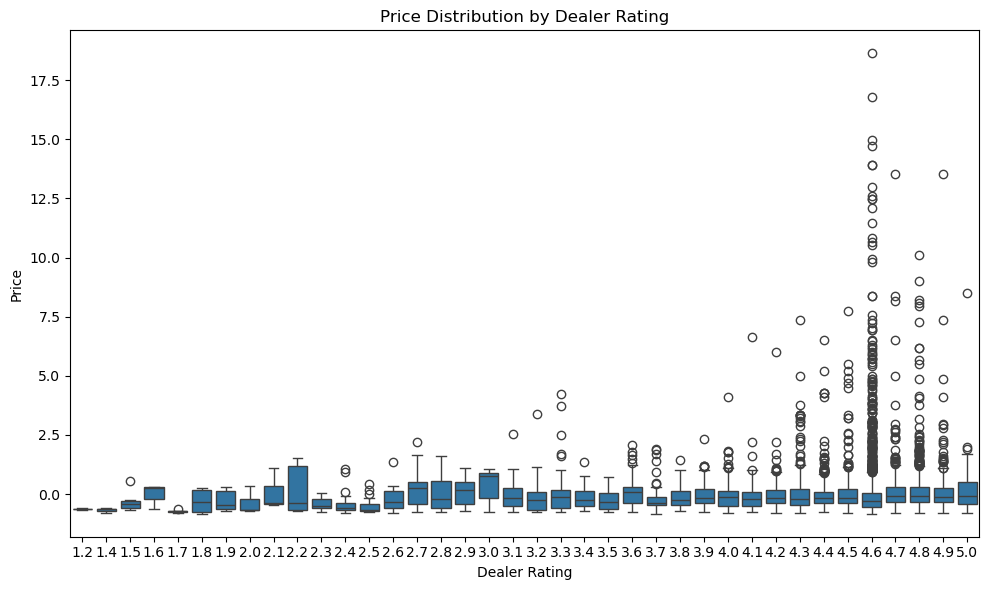

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='Price', data=df)
plt.title("Price Distribution by Dealer Rating")
plt.xlabel("Dealer Rating")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Prices from higher-rated dealers (4.5–5.0) show a noticeably higher median and a greater spread, including several extreme outliers.
Lower-rated dealers (1.2–3.0) tend to cluster around the lower end of the price spectrum, with more consistent pricing and fewer luxury-tier listings.
There is a clear upward trend in price as dealer rating increases, especially past the 4.0 threshold.

# Cylinder Count vs Price

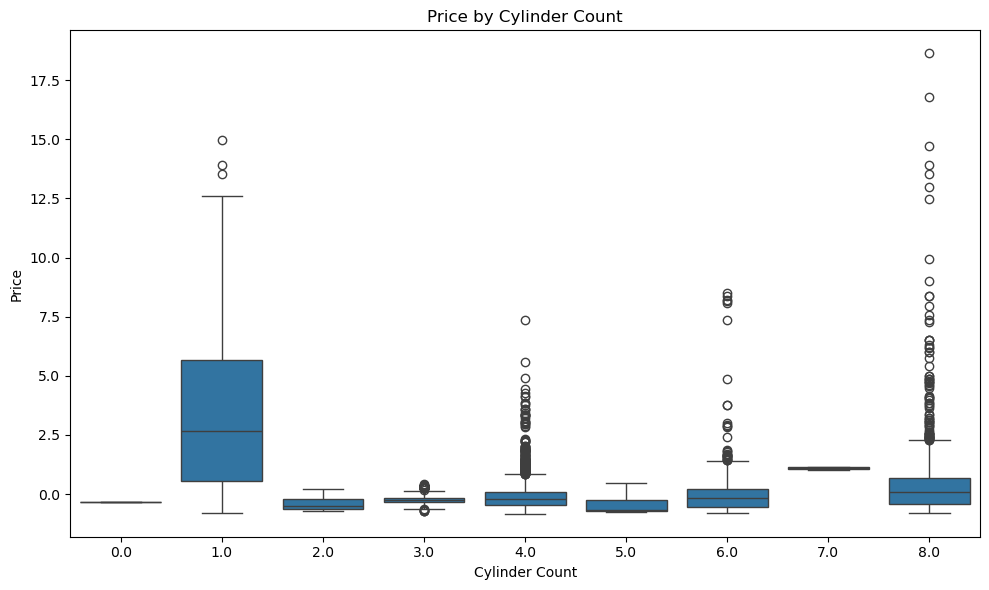

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cylinder', y='Price', data=df)
plt.title("Price by Cylinder Count")
plt.xlabel("Cylinder Count")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

The boxplot shows that vehicles with 6 or 8 cylinders tend to be listed at significantly higher prices.
4-cylinder engines have the widest spread and dominate the lower end of the market

# MPG VS PRICE

C:\Users\skull\anaconda3\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  if left_lim + len(ellipsis) < len(repr_) - right_lim:


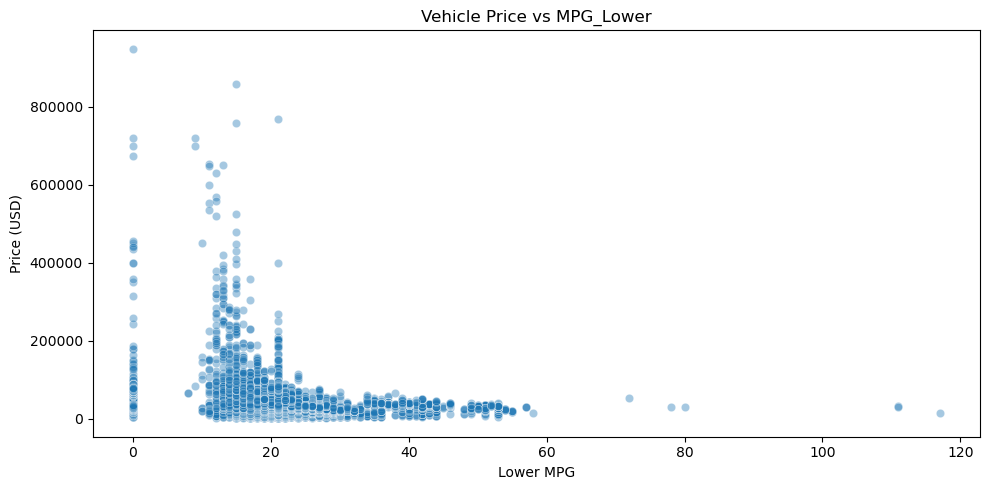

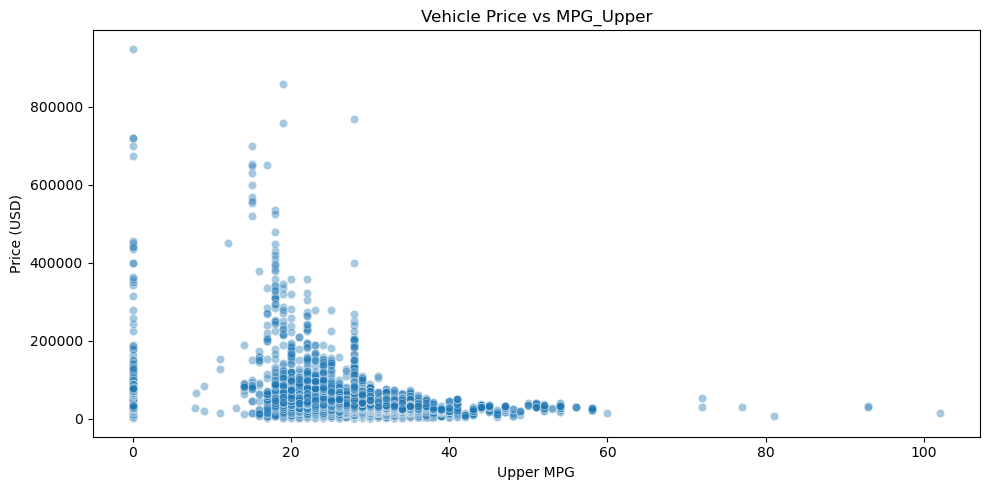

In [92]:
scaler = joblib.load("scaler.pkl")

scaled_cols = ['Mileage', 'Price', 'Year', 'MPG_Lower', 'MPG_Upper']
df = df.dropna(subset=scaled_cols)

unscaled_values = scaler.inverse_transform(df[scaled_cols])
df['UnscaledPrice'] = unscaled_values[:, 1]        # column 1 = Price
df['UnscaledMPG_Lower'] = unscaled_values[:, 3]    # column 3 = City MPG
df['UnscaledMPG_Upper'] = unscaled_values[:, 4]    # column 4 = Highway MPG

# Plot: City MPG vs Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='UnscaledMPG_Lower', y='UnscaledPrice', data=df, alpha=0.4)
plt.title("Vehicle Price vs MPG_Lower")
plt.xlabel("Lower MPG")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

# Plot: Highway MPG vs Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='UnscaledMPG_Upper', y='UnscaledPrice', data=df, alpha=0.4)
plt.title("Vehicle Price vs MPG_Upper")
plt.xlabel("Upper MPG")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


Vehicles with higher MPG tend to cluster in the lower price range, reflecting the economy-class segment.
Vehicles with lower MPG show a wider spread in price, including many of the highest-priced listings — suggesting a mix of performance and luxury vehicles.
While the relationship isn’t strictly linear, the pattern supports the intuition that fuel-efficient cars are often lower-cost, and low-efficiency vehicles are typically premium or high-power models.

# Price by DriveTrain Type

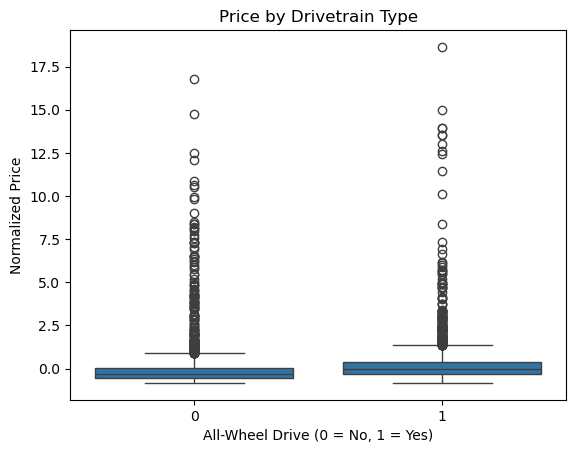

In [12]:
sns.boxplot(x='Drivetrain_All-wheel Drive', y='Price', data=df)
plt.title("Price by Drivetrain Type")
plt.xlabel("All-Wheel Drive (0 = No, 1 = Yes)")
plt.ylabel("Normalized Price")
plt.show()

Vehicles with AWD(1) show a slightly higher median price than those without.
However, the overlap in price ranges between the two groups is substantial.
While there are more high-priced outliers among AWD vehicles, the overall difference is modest.

This visualization is primarily exploratory. While AWD may signal higher-end or utility vehicles, the chart suggests it is not a strong standalone predictor of price.

# Pairwise Feature Relationships

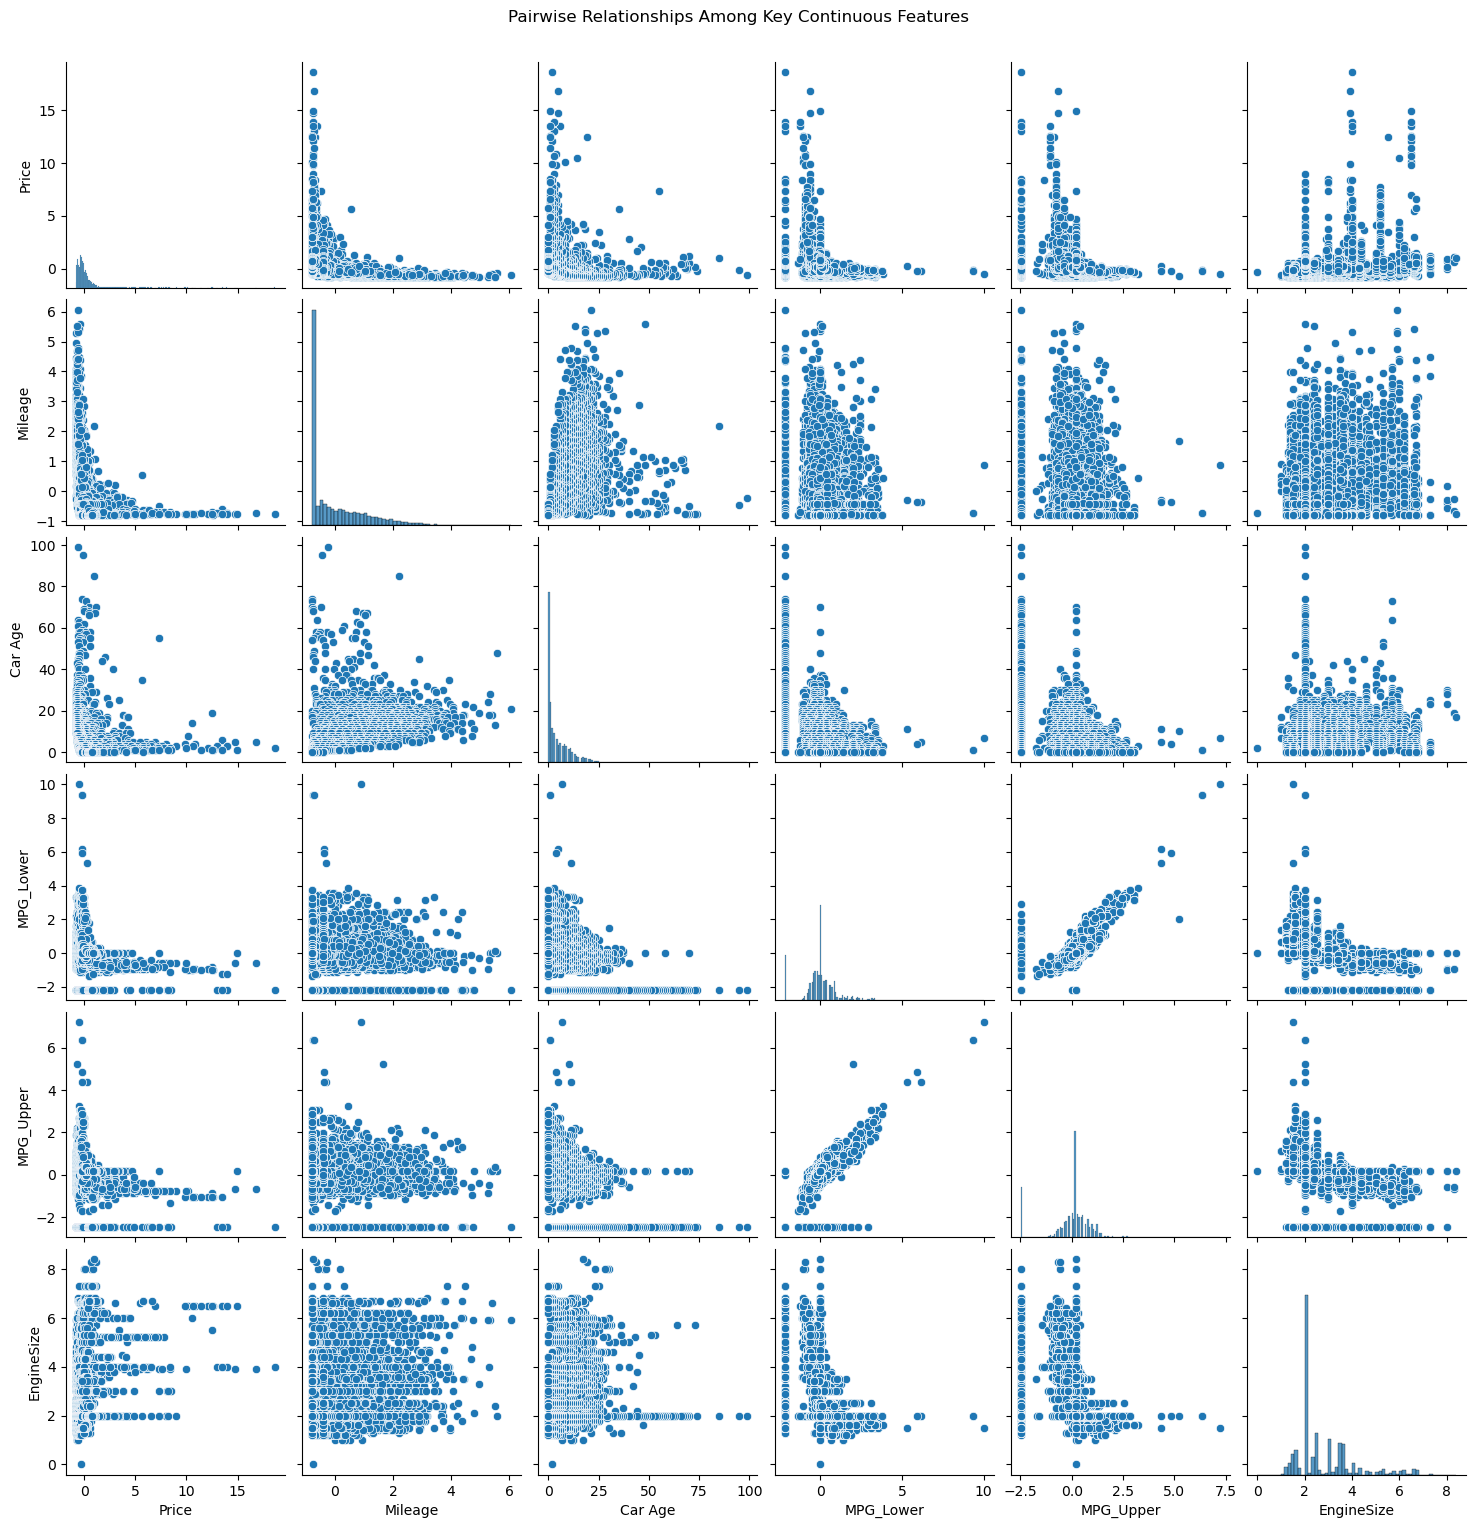

In [29]:
selected_cols = ['Price', 'Mileage', 'Car Age', 'MPG_Lower', 'MPG_Upper', 'EngineSize']
pairplot_df = df[selected_cols].copy()

# Clean EngineSize
pairplot_df = pairplot_df.replace('-', np.nan).dropna()
pairplot_df['EngineSize'] = pairplot_df['EngineSize'].str.extract(r'(\d+\.?\d*)').astype(float)

# Plot
sns.pairplot(pairplot_df)
plt.suptitle("Pairwise Relationships Among Key Continuous Features", y=1.02)
plt.show()

- Price shows a negative curved trend with both Mileage and Car Age, aligning with expectations around vehicle depreciation.
- There's a positive linear relationship between Engine Size and Cylinders, as well as a strong upward trend between MPG_Lower and MPG_Upper, indicating mechanical dependencies.
- Several distributions, especially Price and Mileage, are heavily right-skewed, with a concentration of values in the lower range and a long tail of higher values.
- Some feature combinations (like MPG vs Price) appear noisy or weakly correlated, suggesting their influence may be contextual or non-linear.

This visual reinforces known trends like depreciation and power-price relationships, while also highlighting the need for non-linear models like Random Forest or XGBoost that can handle interaction effects.

# Feature-Based Price Comparison

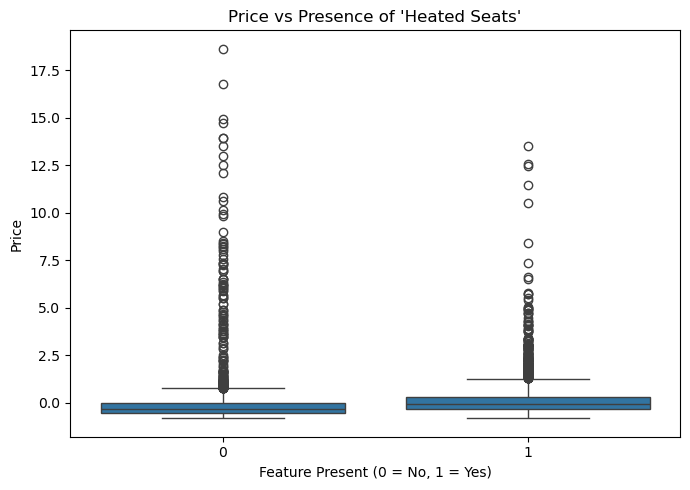

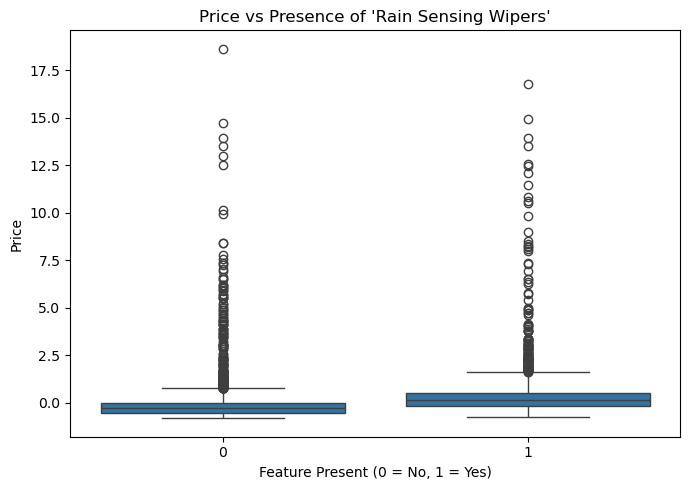

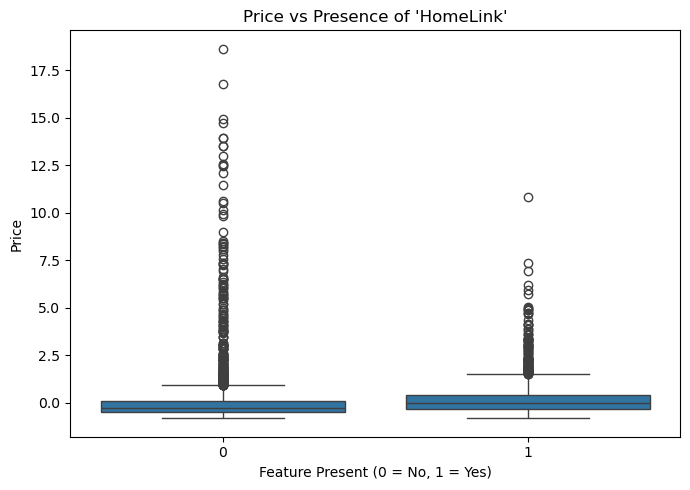

In [44]:
feature_cols = [
    'Convenience Features_Heated Seats',
    'Safety Features_Rain Sensing Wipers',
    'Entertainment Features_HomeLink'
]

for feature in feature_cols:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=feature, y='Price', data=df)
    plt.title(f"Price vs Presence of '{feature.split('_')[-1]}'")
    plt.xlabel("Feature Present (0 = No, 1 = Yes)")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

In all three cases, vehicles with the feature show a slightly higher median price compared to those without. There is also a longer tail of high-priced listings among vehicles that include these features, especially for Heated Seats and Rain Sensing Wipers. However, the difference is not drastic, the majority of price distributions overlap substantially between the two groups.

These features do not strongly predict price on their own but may signal higher trim levels or modern vehicles, especially when combined. Their real value likely comes when interacting with other features (e.g., Make, EngineType), possibly making them useful supporting indicators in a model.